### ANÁLISE DE DESPESAS BRASIL - 2014 a 01/2025 

Nesse notebook vamos analisar as despesas do Brasil ao longo de 2014 até 01/2025, mas os dados podem ser aumentados a qualquer momento, bastando sua disponibilização no Portal da Transparência

Primeiramente, vamos abrir o arquivo com Spark para poder usufruir do seu paralelismo:

In [1]:
# Início do notebook

from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, mean, stddev, when
from pyspark.storagelevel import StorageLevel
import pyspark.sql.functions as F

# Cria a sessão do Spark
spark = SparkSession.builder \
    .appName("AnaliseDespesasBrasil") \
    .master("local[4]") \
    .config("spark.driver.memory", "10g") \
    .config("spark.executor.memory", "3g") \
    .config("spark.local.dir", "/tmp/spark-temp") \
    .config("spark.executor.extraJavaOptions", "-Duser.language=pt -Duser.country=BR") \
    .config("spark.driver.extraJavaOptions", "-Duser.language=pt -Duser.country=BR") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.driver.maxResultSize","2g") \
    .getOrCreate()

# Lê todos os arquivos CSV da pasta "data"
# Usamos opções para header e delimitador
#df = spark.read.options(header=True, delimiter=";", encoding="ISO-8859-1", inferSchema=False).csv("data/raw/*.csv")
parquet_path = "data/Despesas"
df = spark.read.parquet(parquet_path)

print("Schema do dataframe recriado a partir do Parquet:")


# Exibe o esquema para conferir os tipos
df.printSchema()
df.persist(StorageLevel.MEMORY_AND_DISK)
df.show()



25/02/25 00:27:31 WARN Utils: Your hostname, Lionheart.local resolves to a loopback address: 127.0.0.1; using 10.0.0.108 instead (on interface en0)
25/02/25 00:27:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/25 00:27:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/25 00:27:33 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Schema do dataframe recriado a partir do Parquet:
root
 |-- Ano e mês do lançamento: date (nullable = true)
 |-- Código Órgão Superior: integer (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: integer (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: integer (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: integer (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: integer (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: integer (nullable = true)
 |-- Nome Função: string (nullable = true)
 |-- Código Subfução: integer (nullable = true)
 |-- Nome Subfunção: string (nullable = true)
 |-- Código Programa Orçamentário: integer (nullable = true)
 |-- Nome Programa Orçamentário: string (nullable = true)
 |-- Código Ação: string (nullable = true)
 |-- Nome Ação: st

25/02/25 00:27:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------------+---------------------+--------------------+------------------------+----------------------+----------------------+--------------------+-------------+--------------------+---------------------------+-------------------------+-------------+-------------------+---------------+--------------------+----------------------------+--------------------------+-----------+--------------------+-------------------------+--------------------+-----------------------+---------------------+----+---------+----------------+--------------------+------------------+----------------+-----------------+----------------------------------+-------------------+--------------------+--------------------------+------------------------+-----------------------+---------------------+--------------------------+------------------------+----------------------------+---------------------+--------------------+--------------------+---------------+-----------------------------------+--------------------

Como não conhecemos bem os dados, vamos explorar algumas colunas, converter outras e procurar saber com que tipo de dados estamos lidando:

In [ ]:
#ENGENHARIA DOS DADOS (correções de tipos)
# Conversão dos valores monetários
#df = df.withColumn("Valor Empenhado (R$)", regexp_replace(col("Valor Empenhado (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Liquidado (R$)", regexp_replace(col("Valor Liquidado (R$)"), ",", ".").cast("double")) \
##    .withColumn("Valor Pago (R$)", regexp_replace(col("Valor Pago (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Restos a Pagar Inscritos (R$)", regexp_replace(col("Valor Restos a Pagar Inscritos (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Restos a Pagar Cancelado (R$)", regexp_replace(col("Valor Restos a Pagar Cancelado (R$)"), ",", ".").cast("double")) \
#    .withColumn("Valor Restos a Pagar Pagos (R$)", regexp_replace(col("Valor Restos a Pagar Pagos (R$)"), ",", ".").cast("double"))

# Conversão para inteiro somente das colunas que já foram testadas e aprovadas
#int_columns = [
#    "Código Órgão Superior",
#    "Código Órgão Subordinado",
#    "Código Unidade Gestora",
#    "Código Gestão",
#    "Código Unidade Orçamentária",
#    "Código Função",
#    "Código Subfução",
#    "Código Programa Orçamentário",
#    "Código Localizador",
#    "Código Elemento de Despesa",
#    "Código Modalidade da Despesa",
#    "Código Autor Emenda"
#]

#for c in int_columns:
#    df = df.withColumn(c, col(c).cast("integer"))#
#    print(f"A coluna {c} convertida para inteiro.")


Aqui vamos converter o campo de data para um formato de date para permitir um melhor processamento dos dados

In [ ]:
#df = df.withColumn("Ano e mês do lançamento",
#                  F.to_date(F.concat(col("Ano e mês do lançamento"), F.lit("/01")), "yyyy/MM/dd"))


Essa célula usamos para exibir como está o nosso dataframe até o momento. Parece estar bem melhor o schema dele, mais bem estruturado

In [3]:
# Exibe o esquema e alguns registros para conferir
#df.printSchema()
#df.show()


Vamos salvar esse dataframe agora para permitir que tenhamos um arquivo de dados mais enxuto e mais apropriado para a análise. Para passarmos a trabalhar com ele agora, permitindo maior velocidade e performance, vamos gravar e reabrir o dataframe a partir do novo arquivo

In [ ]:
import os
import glob

# Define os caminhos
csv_path_pattern = "data/raw/*.csv"
parquet_path = "data/Despesas"

# Salva o dataframe em parquet com compressão snappy
#df.write.mode("overwrite").option("compression", "snappy").parquet(parquet_path)

# Calcula o tamanho total dos arquivos CSV originais
csv_files = glob.glob(csv_path_pattern)
total_csv_size = sum(os.path.getsize(f) for f in csv_files)

# Calcula o tamanho total dos arquivos do parquet (o parquet é uma pasta com vários arquivos)
total_parquet_size = 0
for root, dirs, files in os.walk(parquet_path):
    for file in files:
        total_parquet_size += os.path.getsize(os.path.join(root, file))

print("Tamanho total dos CSVs (bytes):", total_csv_size)
print("Tamanho total do Parquet com snappy (bytes):", total_parquet_size)


Tamanho total dos CSVs (bytes): 7416331055
Tamanho total do Parquet com snappy (bytes): 450221117


In [3]:
# Exemplo: Cálculo de estatísticas globais para 'Valor_Empenhado'
stats = df.agg(
    mean("Valor Empenhado (R$)").alias("media_emp"),
    stddev("Valor Empenhado (R$)").alias("std_emp")
).collect()[0]

media_emp = stats["media_emp"]
std_emp = stats["std_emp"]

print("Média Valor Empenhado:", media_emp)
print("Desvio Padrão:", std_emp)

# Filtrando possíveis anomalias (usando 3 desvios-padrão como critério)
df_anomalias = df.filter(
    (col("Valor Empenhado (R$)") > media_emp + 3 * std_emp) | 
    (col("Valor Empenhado (R$)") < media_emp - 3 * std_emp)
)

print("Quantidade de registros anômalos (Valor Empenhado):", df_anomalias.count())

Média Valor Empenhado: 4306719.821669389
Desvio Padrão: 813476771.7336167


Quantidade de registros anômalos (Valor Empenhado): 1463


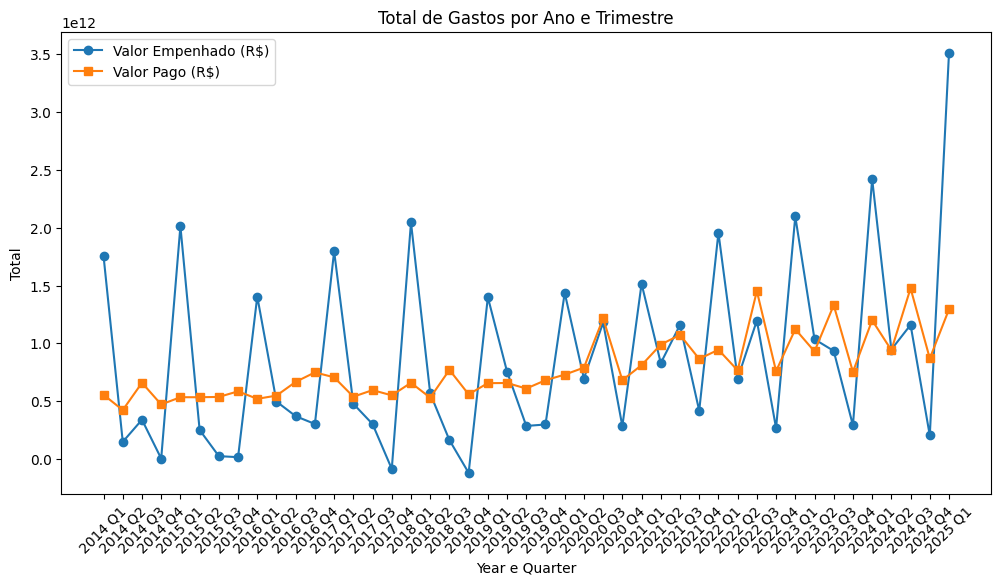

In [2]:
import pandas as pd
# Group data by date and compute the sum for both "Valor Empenhado (R$)" and "Valor Pago (R$)"
df_grouped = df.groupBy(
    F.year("Ano e mês do lançamento").alias("year"),
    F.quarter("Ano e mês do lançamento").alias("quarter")
).agg(
    F.sum("Valor Empenhado (R$)").alias("total_empenhado"),
    F.sum("Valor Pago (R$)").alias("total_pago")
).orderBy("year", "quarter")

# Convert the Spark DataFrame to a pandas DataFrame
df_grouped_pd = df_grouped.toPandas()
df_grouped_pd['year_quarter'] = df_grouped_pd['year'].astype(str) + " Q" + df_grouped_pd['quarter'].astype(str)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_grouped_pd['year_quarter'], df_grouped_pd['total_empenhado'], marker='o', label="Valor Empenhado (R$)")
plt.plot(df_grouped_pd['year_quarter'], df_grouped_pd['total_pago'], marker='s', label="Valor Pago (R$)")
plt.title("Total de Gastos por Ano e Trimestre")
plt.xlabel("Year e Quarter")
plt.ylabel("Total")
plt.xticks(rotation=45)


plt.legend()
plt.show()


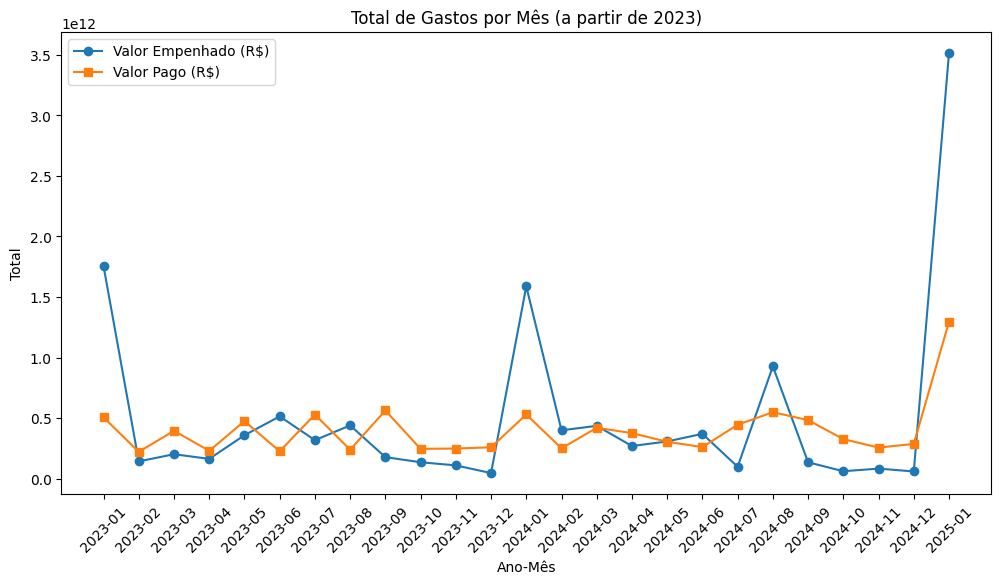

In [3]:
# Filtra apenas os registros a partir do ano de 2023 e cria uma coluna "year_month" no formato "yyyy-MM"
df_filtrado = df.filter(F.year("Ano e mês do lançamento") >= 2023) \
                .withColumn("year_month", F.date_format("Ano e mês do lançamento", "yyyy-MM"))

# Agrupa os dados por mês e calcula a soma dos valores empenhados e pagos
df_grouped_month = df_filtrado.groupBy("year_month").agg(
    F.sum("Valor Empenhado (R$)").alias("total_empenhado"),
    F.sum("Valor Pago (R$)").alias("total_pago")
).orderBy("year_month")

# Converte para pandas DataFrame para facilitar a plotagem
df_grouped_pd_month = df_grouped_month.toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_grouped_pd_month['year_month'], df_grouped_pd_month['total_empenhado'], marker='o', label="Valor Empenhado (R$)")
plt.plot(df_grouped_pd_month['year_month'], df_grouped_pd_month['total_pago'], marker='s', label="Valor Pago (R$)")
plt.title("Total de Gastos por Mês (a partir de 2023)")
plt.xlabel("Ano-Mês")
plt.ylabel("Total")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [4]:
# Registra a tabela temporária para usar SQL
df.createOrReplaceTempView("despesas")

query = """
SELECT 
    year(`Ano e mês do lançamento`) AS ano,
    `Modalidade da Despesa`,
    format_number(sum(`Valor Empenhado (R$)`), 2) AS total_empenhado,
    format_number(sum(`Valor Pago (R$)`), 2) AS total_pago
FROM despesas
WHERE `Ano e mês do lançamento` BETWEEN '2023-01-01' AND '2025-01-31'
GROUP BY year(`Ano e mês do lançamento`), `Modalidade da Despesa`
ORDER BY ano, sum(`Valor Empenhado (R$)`) DESC, sum(`Valor Pago (R$)`) DESC
"""

df_sql = spark.sql(query)
df_sql.show(50)


+----+---------------------+--------------------+--------------------+
| ano|Modalidade da Despesa|     total_empenhado|          total_pago|
+----+---------------------+--------------------+--------------------+
|2023|   Aplicações Diretas|3,647,595,042,945.96|3,489,296,658,501.29|
|2023| Transferências a ...|  275,708,674,175.94|  257,022,436,152.30|
|2023| Transferências a ...|  265,286,038,643.95|  234,761,904,232.80|
|2023| Transferências a ...|   99,063,222,005.99|   92,730,589,427.71|
|2023| Transferências a ...|   32,768,396,306.55|   29,839,875,024.29|
|2023| Aplicação Direta ...|   21,868,652,222.92|   21,022,547,971.18|
|2023| Transferências a ...|   13,444,984,547.27|   10,166,728,587.35|
|2023| Transferências ao...|    2,646,505,507.10|    2,142,594,889.60|
|2023| Transferências Fu...|    1,643,246,526.00|    1,643,246,526.00|
|2023| Transferências Fu...|      927,580,000.00|      927,580,000.00|
|2023| Transferências a ...|      833,203,144.10|      531,427,196.03|
|2023|

In [13]:
import pandas as pd

# Converte o DataFrame Spark para pandas
df_sql_pd = df_sql.toPandas()

# Como os valores de 'total_empenhado' e 'total_pago' vêm formatados como strings, 
# vamos convertê-los para float para reformatá-los no padrão brasileiro.
df_sql_pd['total_empenhado'] = df_sql_pd['total_empenhado'].str.replace(',', '').astype(float)
df_sql_pd['total_pago'] = df_sql_pd['total_pago'].str.replace(',', '').astype(float)

# Função para formatar o número no padrão brasileiro: ponto com separador de milhar e vírgula como separador decimal
def format_brazil(value):
    # Formata com separador de milhar (,) e ponto como separador decimal, em seguida troca: 
    # - vírgula temporária para ponto
    # - ponto para vírgula
    # - ponto temporário para ponto
    return f"{value:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')

# Aplica a formatação nas colunas numéricas
df_sql_pd['total_empenhado'] = df_sql_pd['total_empenhado'].apply(format_brazil)
df_sql_pd['total_pago'] = df_sql_pd['total_pago'].apply(format_brazil)

# Ajusta as opções de exibição do pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(df_sql_pd)


,ano,Modalidade da Despesa,total_empenhado,total_pago
0,2023,Aplicações Diretas,"3.647.595.042.945,96","3.489.296.658.501,29"
1,2023,Transferências a Estados e ao Distrito Federal,"275.708.674.175,94","257.022.436.152,30"
2,2023,Transferências a Municípios,"265.286.038.643,95","234.761.904.232,80"
3,2023,Transferências a Municípios - Fundo a Fundo,"99.063.222.005,99","92.730.589.427,71"
4,2023,Transferências a Estados e ao Distrito Federal - Fundo a Fundo,"32.768.396.306,55","29.839.875.024,29"
5,2023,"Aplicação Direta Decorrente de Operação entre Órgãos, Fundos e Entidades Integrantes dos Orçamentos Fis","21.868.652.222,92","21.022.547.971,18"
6,2023,Transferências a Instituições Privadas sem Fins Lucrativos,"13.444.984.547,27","10.166.728.587,35"
7,2023,Transferências ao Exterior,"2.646.505.507,10","2.142.594.889,60"
8,2023,Transferências Fundo a Fundo aos Municípios à conta de recursos de que tratam os §§ 1º e 2º do art. 24,"1.643.246.526,00","1.643.246.526,00"
9,2023,Transferências Fundo a Fundo aos Estados e ao Distrito Federal à conta de recursos de que tratam os §§ 1º,"927.580.000,00","927.580.000,00"


In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.linalg import SparseVector
import numpy as np

# Seleciona apenas as colunas que começam com "Nome"
text_fields = [
    'Nome Órgão Superior', 'Nome Órgão Subordinado',
    'Nome Unidade Gestora', 'Nome Gestão', 'Nome Unidade Orçamentária', 'Nome Função',
    'Nome Subfunção', 'Nome Programa Orçamentário', 'Nome Ação',
    'Nome Subtítulo', 'Nome Localizador', 'Nome Autor Emenda', 'Nome Categoria Econômica',
    'Nome Grupo de Despesa', 'Nome Elemento de Despesa', 'Modalidade da Despesa'  
]

# Define uma lista simples de stopwords em português
stopwords = [
    "a","as","à","às","o","os","e","é","de","da","do","das","dos","em","na","nas","no","nos",
    "um","uma","para","com","que","se","como","por","mas","mais","foi","ao","entre","sem",
    "sua","seu","só","também","está","este","esta","estão","há","já","vamos","pode","não",
    "qual","quando","são","ser","sobre","todos","vai","vem","você","ainda","além","até",
    "depois","desde","essa","esse","estes","eu","faz","fazer","fazia","faziam","fazíamos",
    "fazíeis","fazem","fazem","fazemos","fazerem","fizeram","fizerem","fizermos","fazes",
    "a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r",
    "s", "t", "u", "v", "w", "x", "y", "z", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0",
    "aos", "sem", "com", "em", "na", "no", "nas", "nos", "pela", "pelo", "pelas", "pelos",
    "sobre", "sob", "ante", "após", "até", "com", "contra", "de", "desde", "em", "entre",
    "para", "perante", "por", "sem", "sob", "sobre", "trás", "a", "o", "os", "a", "as", "à",
    "às", "um", "uns", "uma", "umas", "me", "te", "se", "lhe", "lhes", "nos", "vos", "lhes",
    "meu", "minha", "meus", "minhas", "teu", "tua", "teus", "tuas", "seu", "sua", "seus",
    "suas", "nosso", "nossa", "nossos", "nossas", "vosso", "vossa", "vossos", "vossas",
    "quem", "cujo", "cuja", "cujos", "cujas", "quais", "onde"
]

# Concatena todas as colunas "Nome*" em letras minúsculas e remove pontuação
df_concat = df.filter(F.year("Ano e mês do lançamento") >= 2023).select(
    F.lower(
        F.regexp_replace(
            F.concat_ws(" ", *[F.col(c) for c in text_fields]),
            "[^\\p{L}\\p{Nd}\\s]+", ""
        )
    ).alias("all_names")
)

# Divide em palavras e explode
df_words = df_concat.select(F.explode(F.split(F.col("all_names"), "\\s+")).alias("word"))

# Remove vazios e stopwords
df_filtered = df_words.filter(
    (F.col("word") != "") &
    (~F.col("word").isin(stopwords))
)
df_filtered.persist()

# 1. Tokenize the concatenated text (each row is a document)
tokenizer = Tokenizer(inputCol="all_names", outputCol="tokens")
df_tokens = tokenizer.transform(df_concat)

# 2. Remove stopwords (using our custom list)
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens").setStopWords(stopwords)
df_filtered_tokens = remover.transform(df_tokens)

# 3. Compute term frequencies using CountVectorizer (this also builds the vocabulary)
cv = CountVectorizer(inputCol="filtered_tokens", outputCol="tf_features")
cv_model = cv.fit(df_filtered_tokens)
df_tf = cv_model.transform(df_filtered_tokens)

# 4. Compute IDF to get the TF-IDF scores per document
idf = IDF(inputCol="tf_features", outputCol="tfidf_features")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

# 5. Sum the TF-IDF scores for each term across all documents
vocab = cv_model.vocabulary
vocab_size = len(vocab)

# Each row in tfidf_features is a SparseVector; convert to dense array and sum them.
tfidf_sum = df_tfidf.select("tfidf_features").rdd.map(lambda row: row[0]).aggregate(
    np.zeros(vocab_size),
    lambda acc, vec: acc + np.array(vec.toArray()),
    lambda acc1, acc2: acc1 + acc2
)

# 6. Create a DataFrame ranking terms by their global TF-IDF score
word_tfidf = [(vocab[i], float(tfidf_sum[i])) for i in range(vocab_size)]
df_top = spark.createDataFrame(word_tfidf, ["word", "tf_idf"]) \
              .orderBy("tf_idf", "word", ascending=[False, True])


25/02/23 19:18:59 WARN CacheManager: Asked to cache already cached data.


In [13]:
df_top.write.mode("overwrite").csv("data/db/word_count.csv", header=True, sep=";")
df_top.select("word").write.mode("overwrite").csv("data/db/word.csv", header=True, sep=";")

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from pyspark.sql import functions as F
from pyspark.sql.functions import col, monotonically_increasing_id, when
from pyspark.sql.types import IntegerType
import unicodedata
import re

# Função para remover acentos e cedilhas
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

# Define os campos de texto usados em todas as verificações de palavras-chave
text_fields = [
    'Nome Órgão Superior', 'Nome Órgão Subordinado',
    'Nome Unidade Gestora', 'Nome Gestão', 'Nome Unidade Orçamentária', 'Nome Função',
    'Nome Subfunção', 'Nome Programa Orçamentário', 'Nome Ação',
    'Nome Subtítulo', 'Nome Localizador', 'Nome Autor Emenda', 'Nome Categoria Econômica',
    'Nome Grupo de Despesa', 'Nome Elemento de Despesa', 'Modalidade da Despesa'
]

# Carrega palavras suspeitas de um arquivo CSV usando Pandas
suspicious_df = pd.read_csv('data/suspicious_words/suspicious_words.csv', sep=';')
suspicious_df['category'] = suspicious_df['category'].str.strip()
suspicious_df['word'] = suspicious_df['word'].str.lower().apply(remove_accents)

# Cria dicionário de categorias para palavras
categories = {category: group['word'].tolist() for category, group in suspicious_df.groupby('category')}

# Compila padrões regex para cada categoria
patterns = {
    cat: re.compile(r'\b(' + '|'.join(re.escape(remove_accents(kw.lower())) for kw in keywords) + r')\b')
    for cat, keywords in categories.items()
}

# Define UDFs para cada categoria
def create_udf(pattern):
    def _udf(text):
        if text is None:
            return 0
        text = remove_accents(text.lower())
        return 1 if pattern.search(text) else 0
    return F.udf(_udf, IntegerType())

category_udfs = {cat: create_udf(pattern) for cat, pattern in patterns.items()}

# Filtra o DataFrame original
df_sample = df.filter((F.year("Ano e mês do lançamento") >= 2023) &
                      (col("Valor Empenhado (R$)") > 0) &
                      (col("Valor Pago (R$)") > 0))

# Converte a coluna de data para formato datetime
df_sample = df_sample.withColumn("Ano e mês do lançamento", F.to_date(col("Ano e mês do lançamento")))

# Adiciona uma coluna de ID único
df_sample = df_sample.withColumn('id', monotonically_increasing_id())

# Cria coluna de texto concatenado
df_sample = df_sample.withColumn('text', F.lower(F.concat_ws(' ', *[col(f).cast("string") for f in text_fields])))

# Cria features binárias para cada categoria, com nomes de colunas sem espaços
for cat, udf_func in category_udfs.items():
    clean_cat = cat.replace(' ', '_')  # Substitui espaços por underscores
    df_sample = df_sample.withColumn(f'contains_{clean_cat}_keyword', udf_func(col('text')))

# Cria outras features binárias
df_sample = df_sample.withColumn('is_emenda', when(col('Nome Autor Emenda') == 'SEM EMENDA', 0).otherwise(1))

# Cria features numéricas
df_sample = df_sample.withColumn('paid_to_committed', col('Valor Pago (R$)') / col('Valor Empenhado (R$)'))
df_sample = df_sample.withColumn('paid_minus_committed', col('Valor Pago (R$)') - col('Valor Empenhado (R$)'))
df_sample = df_sample.withColumn('year', F.year(col('Ano e mês do lançamento')))
df_sample = df_sample.withColumn('month', F.month(col('Ano e mês do lançamento')))

# Codificação de frequência para colunas categóricas
categorical_cols = [
    'Código Órgão Superior', 'Código Programa Orçamentário', 'UF',
    'Código Categoria Econômica', 'Código Grupo de Despesa',
    'Código Elemento de Despesa', 'Código Modalidade da Despesa'
]

for cat_col in categorical_cols:
    freq_df = df_sample.groupBy(cat_col).count()
    total = df_sample.count()
    freq_df = freq_df.withColumn(cat_col + '_freq', col('count') / F.lit(total))
    df_sample = df_sample.join(freq_df.select(cat_col, cat_col + '_freq'), cat_col, 'left')

# Lista de outras features para o modelo, incluindo as novas colunas
other_features = [
    'Valor Restos a Pagar Inscritos (R$)', 
    'Valor Restos a Pagar Cancelado (R$)', 
    'Valor Restos a Pagar Pagos (R$)'
]
keyword_features = [f'contains_{cat.replace(" ", "_")}_keyword' for cat in categories]  # Ajuste aqui também
features = [
    'Valor Empenhado (R$)', 'Valor Liquidado (R$)', 'Valor Pago (R$)',
    'paid_to_committed', 'paid_minus_committed', 'year', 'month',
    'is_emenda'
] + keyword_features + [col + '_freq' for col in categorical_cols] + other_features

# Trata valores ausentes para todas as features
for feature in features:
    df_sample = df_sample.withColumn(feature, when(col(feature).isNull(), 0).otherwise(col(feature)))

# Converte para Pandas apenas as features e o ID
pdf = df_sample.select(['id'] + features).toPandas()

# Treina o Isolation Forest
iso_forest = IsolationForest(random_state=42, contamination=0.05)
iso_forest.fit(pdf[features])

# Adiciona previsões ao DataFrame Pandas
pdf['anomaly_pred'] = iso_forest.predict(pdf[features])

# Converte o DataFrame de previsões de volta para Spark
pred_df = spark.createDataFrame(pdf[['id', 'anomaly_pred']])

# Faz o join com o df_sample usando o 'id'
df_result = df_sample.join(pred_df, 'id', 'inner')

# Separa anomalias
anomalias_emendas = df_result.filter((col('anomaly_pred') == -1) & (col('is_emenda') == 1))
anomalias_desgoverno = df_result.filter((col('anomaly_pred') == -1) & (col('is_emenda') == 0))
anomalias_emendas.printSchema() 

# Salva os resultados em formato Parquet
anomalias_emendas.write.mode('overwrite').parquet('data/relatorios/anomalias_emendas')
anomalias_desgoverno.write.mode('overwrite').parquet('data/relatorios/anomalias_desgoverno')

# Mensagem de confirmação
print("Arquivos salvos com sucesso:")
print("- data/relatorios/anomalias_emendas")
print("- data/relatorios/anomalias_desgoverno")

root
 |-- id: long (nullable = false)
 |-- Código Modalidade da Despesa: integer (nullable = true)
 |-- Código Elemento de Despesa: integer (nullable = true)
 |-- Código Grupo de Despesa: string (nullable = true)
 |-- Código Categoria Econômica: string (nullable = true)
 |-- UF: string (nullable = true)
 |-- Código Programa Orçamentário: integer (nullable = true)
 |-- Código Órgão Superior: integer (nullable = true)
 |-- Ano e mês do lançamento: date (nullable = true)
 |-- Nome Órgão Superior: string (nullable = true)
 |-- Código Órgão Subordinado: integer (nullable = true)
 |-- Nome Órgão Subordinado: string (nullable = true)
 |-- Código Unidade Gestora: integer (nullable = true)
 |-- Nome Unidade Gestora: string (nullable = true)
 |-- Código Gestão: integer (nullable = true)
 |-- Nome Gestão: string (nullable = true)
 |-- Código Unidade Orçamentária: integer (nullable = true)
 |-- Nome Unidade Orçamentária: string (nullable = true)
 |-- Código Função: integer (nullable = true)
 |-- N

25/02/25 00:41:37 WARN TaskSetManager: Stage 48 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
25/02/25 00:42:21 WARN TaskSetManager: Stage 78 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


Arquivos salvos com sucesso:
- data/relatorios/anomalias_emendas
- data/relatorios/anomalias_desgoverno


In [3]:
anomalias_desgoverno = spark.read.parquet("data/relatorios/anomalias_desgoverno")
anomalias_desgoverno.count()


21488

25/02/25 02:59:19 WARN TaskSetManager: Stage 105 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


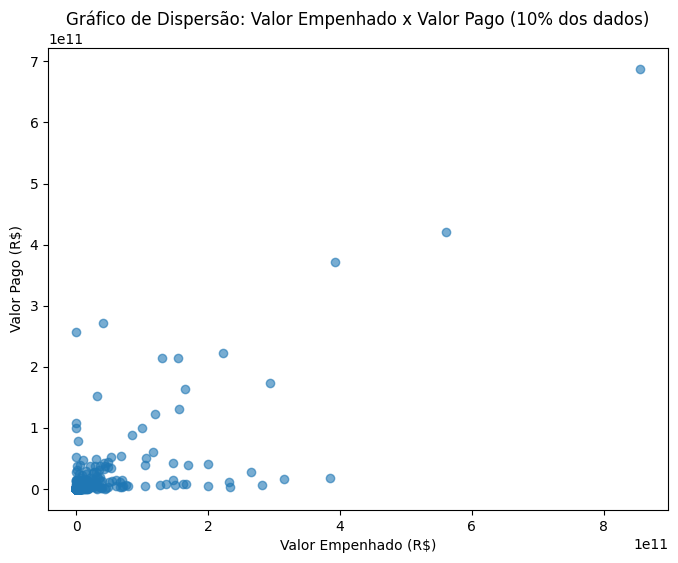

In [3]:
# Amostra de 10% dos dados de anomalias_desgoverno e anomalias_emendas
#amostra_desgoverno = anomalias_desgoverno.sample(False, 0.1, seed=42)
#amostra_emendas = anomalias_emendas.sample(False, 0.1, seed=42)

# Junta as amostras

# Converte para pandas para facilitar a plotagem
df_amostra = anomalias_desgoverno.select("Valor Empenhado (R$)", "Valor Pago (R$)").toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df_amostra["Valor Empenhado (R$)"], df_amostra["Valor Pago (R$)"], alpha=0.6)
plt.xlabel("Valor Empenhado (R$)")
plt.ylabel("Valor Pago (R$)")
plt.title("Gráfico de Dispersão: Valor Empenhado x Valor Pago (10% dos dados)")
plt.show()

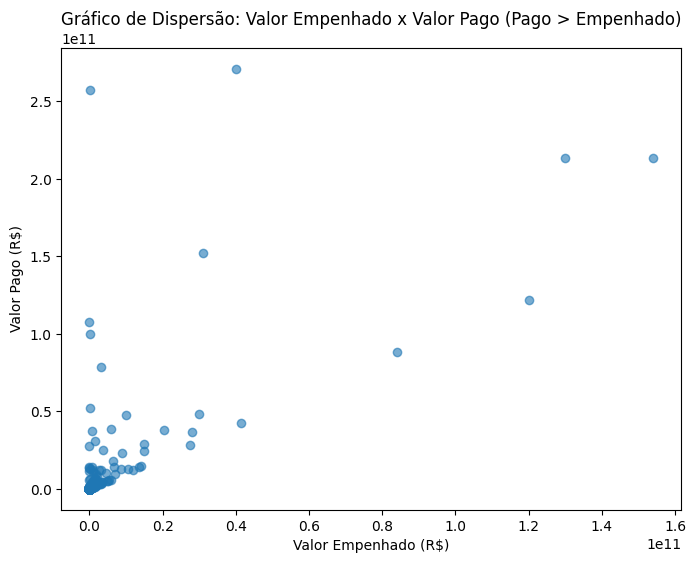

In [5]:
# Filtrar apenas os registros onde "Valor Pago (R$)" é maior que "Valor Empenhado (R$)"
df_filtered = anomalias_desgoverno.filter(col("Valor Pago (R$)") > col("Valor Empenhado (R$)"))

# Converter para pandas para facilitar a plotagem
df_amostra = df_filtered.select("Valor Empenhado (R$)", "Valor Pago (R$)").toPandas()

plt.figure(figsize=(8,6))
plt.scatter(df_amostra["Valor Empenhado (R$)"], df_amostra["Valor Pago (R$)"], alpha=0.6)
plt.xlabel("Valor Empenhado (R$)")
plt.ylabel("Valor Pago (R$)")
plt.title("Gráfico de Dispersão: Valor Empenhado x Valor Pago (Pago > Empenhado)")
plt.show()


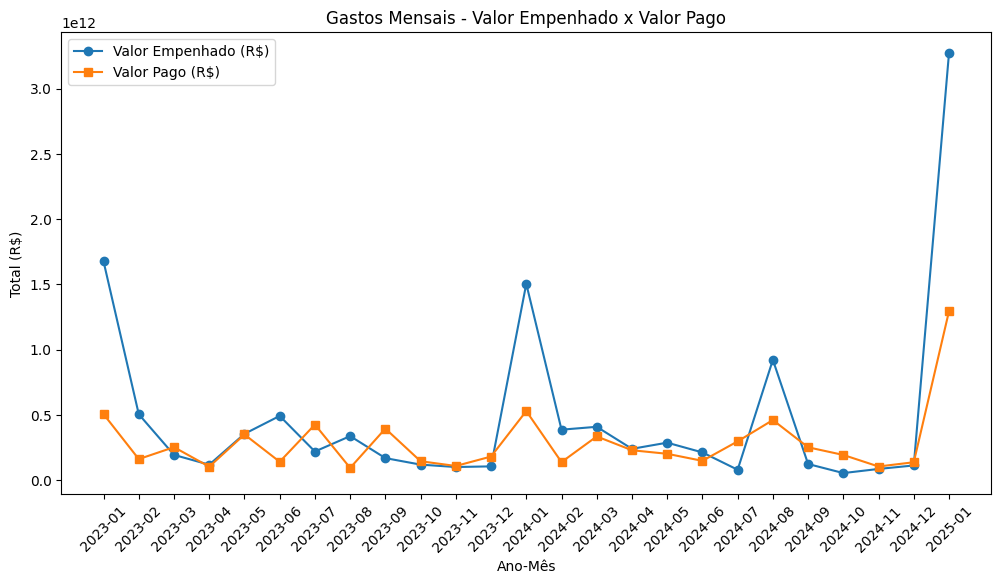

In [6]:
from pyspark.sql.functions import col, date_format, sum as _sum

# Agrupa os dados mensais dos gastos em anomalias_desgoverno
anomalias_monthly = anomalias_desgoverno.withColumn(
    "year_month", date_format(col("Ano e mês do lançamento"), "yyyy-MM")
).groupBy("year_month").agg(
    _sum("Valor Empenhado (R$)").alias("total_empenhado"),
    _sum("Valor Pago (R$)").alias("total_pago")
).orderBy("year_month")

# Converte para pandas para facilitar a plotagem
anomalias_monthly_pd = anomalias_monthly.toPandas()

# Cria o gráfico comparativo
plt.figure(figsize=(12, 6))
plt.plot(anomalias_monthly_pd["year_month"], anomalias_monthly_pd["total_empenhado"],
         marker='o', label="Valor Empenhado (R$)")
plt.plot(anomalias_monthly_pd["year_month"], anomalias_monthly_pd["total_pago"],
         marker='s', label="Valor Pago (R$)")
plt.title("Gastos Mensais - Valor Empenhado x Valor Pago")
plt.xlabel("Ano-Mês")
plt.ylabel("Total (R$)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

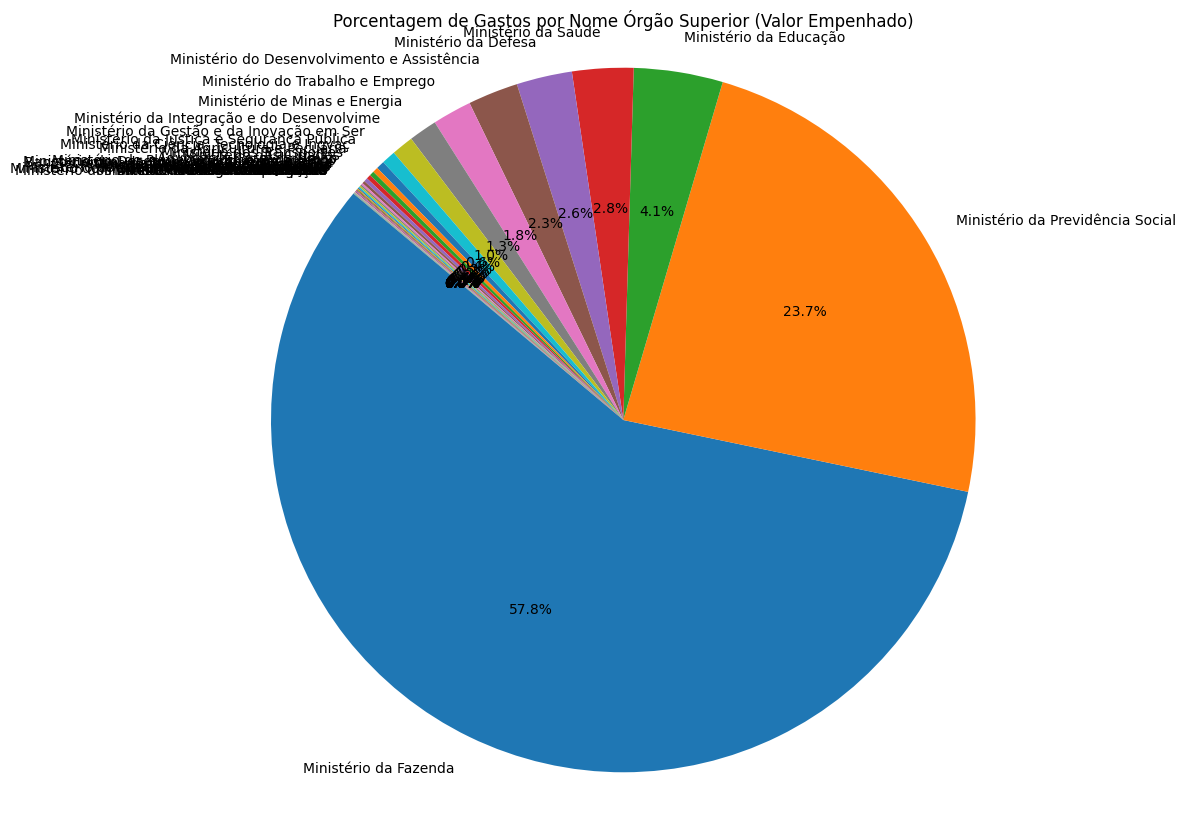

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:684)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:650)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:626)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:583)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:540)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


In [9]:
# Agrega os gastos por "Nome Órgão Superior" usando a soma de "Valor Empenhado (R$)"
df_gastos = anomalias_desgoverno.groupBy("Nome Órgão Superior") \
    .agg(F.sum("Valor Empenhado (R$)").alias("total_emp"))

# Converte para pandas para facilitar a plotagem
gastos_pd = df_gastos.toPandas()
gastos_pd = gastos_pd.sort_values(by="total_emp", ascending=False)

# Plota o gráfico de pizza
plt.figure(figsize=(10,10))
plt.pie(gastos_pd['total_emp'], labels=gastos_pd['Nome Órgão Superior'], autopct='%1.1f%%', startangle=140)
plt.title("Porcentagem de Gastos por Nome Órgão Superior (Valor Empenhado)")
plt.axis('equal')
plt.show()


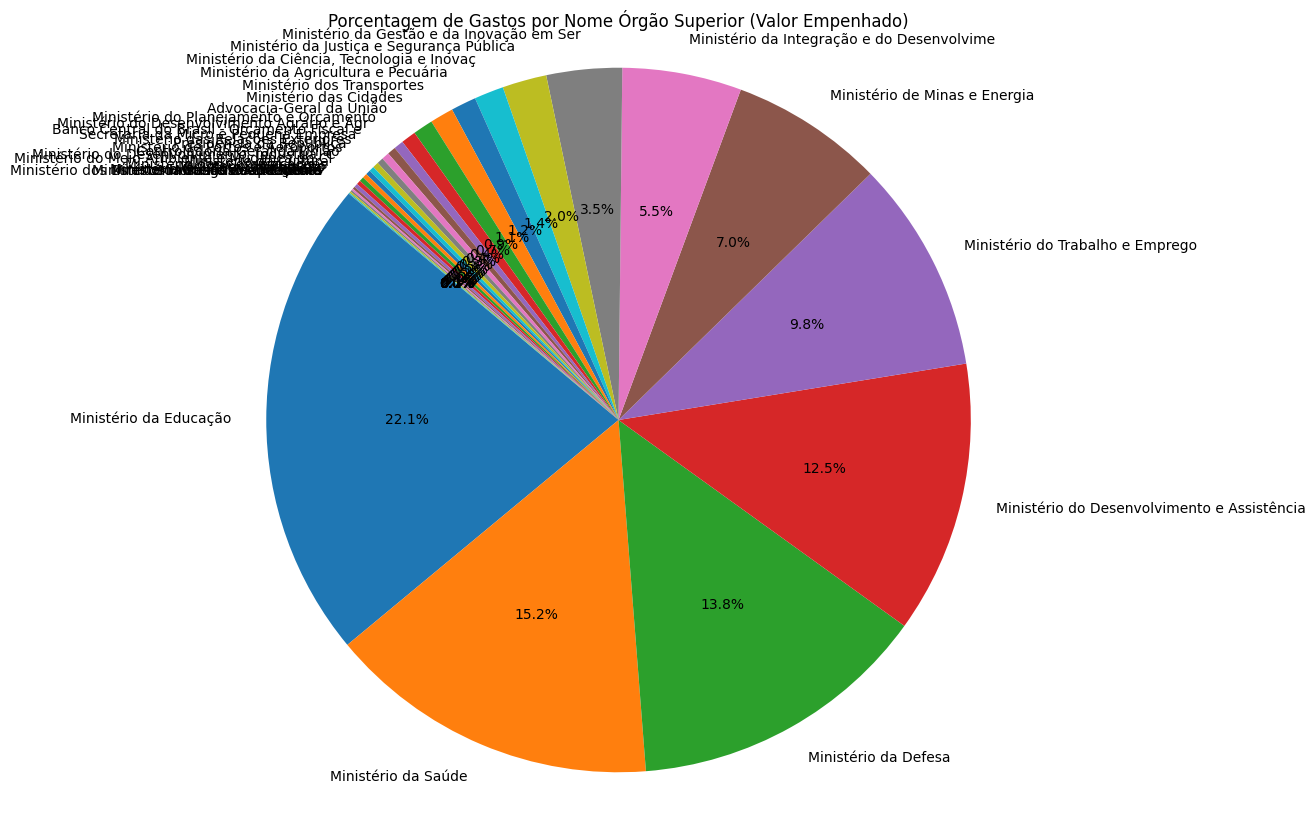

In [10]:
# Agrega os gastos por "Nome Órgão Superior", excluindo os ministérios especificados,
# usando a soma de "Valor Empenhado (R$)"
df_gastos = anomalias_desgoverno.filter(
    ~F.col("Nome Órgão Superior").isin(["Ministério da Fazenda", "Ministério da Previdência Social"])
).groupBy("Nome Órgão Superior") \
 .agg(F.sum("Valor Empenhado (R$)").alias("total_emp"))

# Converte para pandas para facilitar a plotagem
gastos_pd = df_gastos.toPandas()
gastos_pd = gastos_pd.sort_values(by="total_emp", ascending=False)

# Plota o gráfico de pizza
plt.figure(figsize=(10,10))
plt.pie(gastos_pd['total_emp'], labels=gastos_pd['Nome Órgão Superior'], autopct='%1.1f%%', startangle=140)
plt.title("Porcentagem de Gastos por Nome Órgão Superior (Valor Empenhado)")
plt.axis('equal')
plt.show()


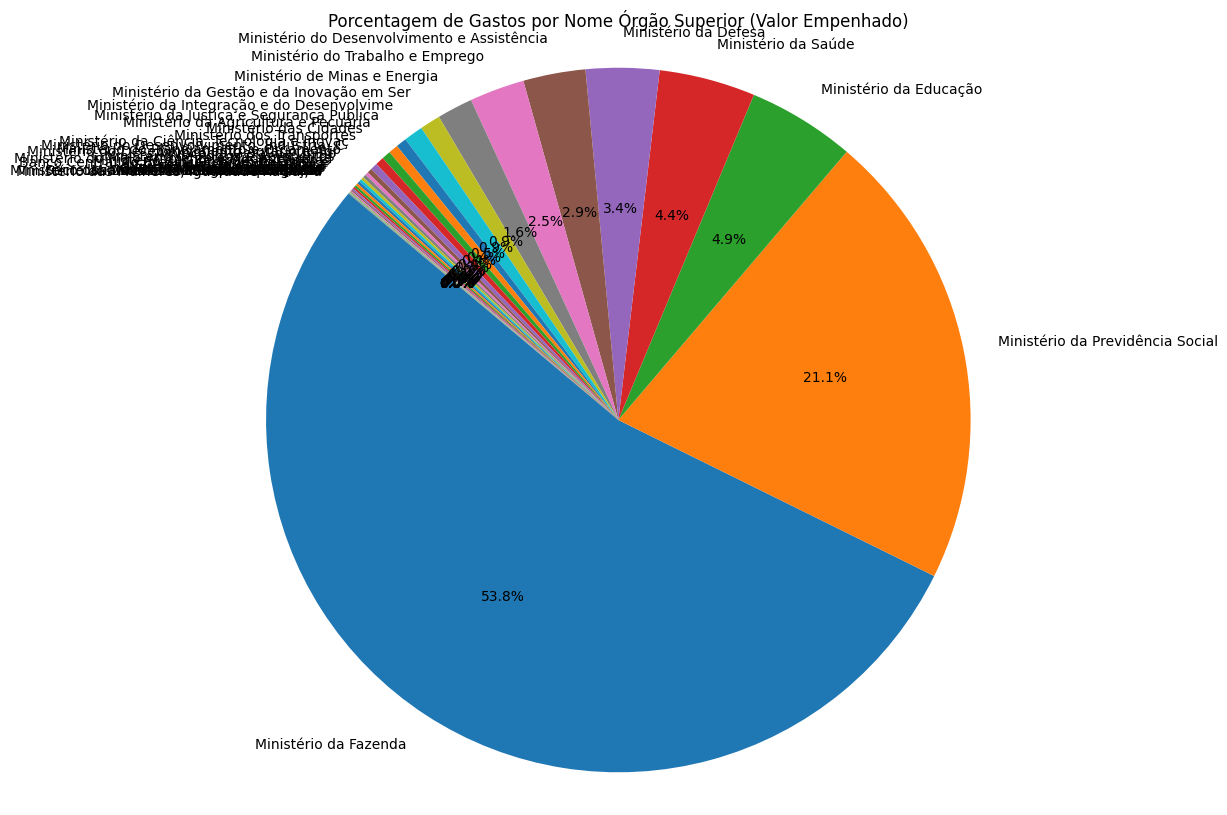

In [12]:
# Agrega os gastos por "Nome Órgão Superior" usando a soma de "Valor Empenhado (R$)"
df_gastos = df.groupBy("Nome Órgão Superior") \
    .agg(F.sum("Valor Empenhado (R$)").alias("total_emp"))

# Converte para pandas para facilitar a plotagem
gastos_pd = df_gastos.toPandas()
gastos_pd = gastos_pd.sort_values(by="total_emp", ascending=False)

# Plota o gráfico de pizza
plt.figure(figsize=(10,10))
plt.pie(gastos_pd['total_emp'], labels=gastos_pd['Nome Órgão Superior'], autopct='%1.1f%%', startangle=140)
plt.title("Porcentagem de Gastos por Nome Órgão Superior (Valor Empenhado)")
plt.axis('equal')
plt.show()


In [4]:
# Seleciona apenas as colunas de interesse: datas, textos e valores
selected_cols = [
    "Ano e mês do lançamento", 
    'Nome Órgão Superior', 'Nome Órgão Subordinado',
    'Nome Unidade Gestora', 'Nome Gestão', 'Nome Unidade Orçamentária', 'Nome Função',
    'Nome Subfunção', 'Nome Programa Orçamentário', 'Nome Ação',
    'Nome Subtítulo', 'Nome Localizador', 'Nome Categoria Econômica',
    'Nome Grupo de Despesa', 'Nome Elemento de Despesa', 'Modalidade da Despesa', 'UF', 'Município',
    "Valor Empenhado (R$)", 
    "Valor Pago (R$)"
]

df_anom_temp = anomalias_desgoverno.select(*selected_cols)
df_anom_pd = df_anom_temp.toPandas()

# Cria novas colunas com os valores formatados
df_anom_pd["Valor Empenhado Formatado"] = df_anom_pd["Valor Empenhado (R$)"].apply(
    lambda x: f"{x:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')
)
df_anom_pd["Valor Pago Formatado"] = df_anom_pd["Valor Pago (R$)"].apply(
    lambda x: f"{x:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')
)

# Ordena pelo valor numérico original
df_anom_pd = df_anom_pd.sort_values(by="Valor Pago (R$)", ascending=False)

# Exibe os dados sem mostrar as colunas numéricas originais
display(df_anom_pd.drop(columns=["Valor Empenhado (R$)", "Valor Pago (R$)"]))

25/02/25 03:00:51 WARN TaskSetManager: Stage 111 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


,Ano e mês do lançamento,Nome Órgão Superior,Nome Órgão Subordinado,Nome Unidade Gestora,Nome Gestão,Nome Unidade Orçamentária,Nome Função,Nome Subfunção,Nome Programa Orçamentário,Nome Ação,Nome Subtítulo,Nome Localizador,Nome Categoria Econômica,Nome Grupo de Despesa,Nome Elemento de Despesa,Modalidade da Despesa,UF,Município,Valor Empenhado Formatado,Valor Pago Formatado
2190,2025-01-01,Ministério da Fazenda,Ministério da Fazenda - Unidades com vínculo d...,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,TESOURO NACIONAL,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,Encargos especiais,Refinanciamento da dívida interna,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,DESPESAS DE CAPITAL,Amortização/Refinanciamento da Dívida,Principal Corrigido da Dívida Mobiliária Re,Aplicações Diretas,None,None,"855.008.750.000,00","688.103.922.717,94"
16633,2023-01-01,Ministério da Fazenda,Ministério da Fazenda - Unidades com vínculo d...,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,TESOURO NACIONAL,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,Encargos especiais,Refinanciamento da dívida interna,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,DESPESAS DE CAPITAL,Amortização/Refinanciamento da Dívida,Principal Corrigido da Dívida Mobiliária Re,Aplicações Diretas,None,None,"560.070.000.000,00","419.789.626.035,50"
8873,2024-01-01,Ministério da Fazenda,Ministério da Fazenda - Unidades com vínculo d...,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,TESOURO NACIONAL,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,Encargos especiais,Refinanciamento da dívida interna,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,DESPESAS DE CAPITAL,Amortização/Refinanciamento da Dívida,Principal Corrigido da Dívida Mobiliária Re,Aplicações Diretas,None,None,"392.010.000.000,00","371.480.131.981,24"
12449,2023-09-01,Ministério da Fazenda,Ministério da Fazenda - Unidades com vínculo d...,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,TESOURO NACIONAL,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,Encargos especiais,Refinanciamento da dívida interna,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,DESPESAS DE CAPITAL,Amortização/Refinanciamento da Dívida,Principal Corrigido da Dívida Mobiliária Re,Aplicações Diretas,None,None,"40.004.000.000,00","271.102.967.590,86"
11209,2023-07-01,Ministério da Fazenda,Ministério da Fazenda - Unidades com vínculo d...,COORD.GERAL DE CONTROLE DA DIVIDA PUBLICA,TESOURO NACIONAL,REC.SOB SUPERV. DO ME - DIVIDA PUB FED,Encargos especiais,Refinanciamento da dívida interna,OPERACOES ESPECIAIS: REFINANCIAMENTO DA DIVIDA...,REFINANCIAMENTO DA DIVIDA PUBLICA MOBILIARIA F...,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIONAL,REFINANCIAMENTO DA DIVIDA PUBLICA MOB - NACIO,DESPESAS DE CAPITAL,Amortização/Refinanciamento da Dívida,Principal Corrigido da Dívida Mobiliária Re,Aplicações Diretas,None,None,"23.000.000,00","257.302.005.899,38"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14122,2023-05-01,"Ministério da Ciência, Tecnologia e Inovaç","Ministério da Ciência, Tecnologia e Inovação -...",INSTIT.NACIONAL DE PESQUISA DA AMAZONIA-INPA,TESOURO NACIONAL,"MINIST. DA CIENCIA, TECNOLOGIA E INOVOVACAO",Ciência e Tecnologia,Administração geral,PROGRAMA DE GESTAO E MANUTENCAO DO PODER EXECU...,ADMINISTRACAO DA UNIDADE,ADMINISTRACAO DA UNIDADE - NACIONAL,ADMINISTRACAO DA UNIDADE - NACIONAL,DESPESAS DE CAPITAL,Investimentos,Obras e Instalações,Aplicações Diretas,None,None,"0,03","0,03"


In [6]:
import pandas as pd

df_woke = anomalias_desgoverno.filter(col("contains_Progressism/woke_keyword") == 1)

selected_cols = [
    "Ano e mês do lançamento", 
    'Nome Órgão Superior', 'Nome Órgão Subordinado',
    'Nome Unidade Gestora', 'Nome Gestão', 'Nome Unidade Orçamentária', 'Nome Função',
    'Nome Subfunção', 'Nome Programa Orçamentário', 'Nome Ação',
    'Nome Subtítulo', 'Nome Localizador', 'Nome Categoria Econômica',
    'Nome Grupo de Despesa', 'Nome Elemento de Despesa', 'Modalidade da Despesa', 'UF', 'Município',
    "Valor Empenhado (R$)", 
    "Valor Pago (R$)"
]

df_anom_temp = anomalias_desgoverno.select(*selected_cols)
pdf_woke = df_anom_temp.filter(col("contains_Progressism/woke_keyword") == 1).orderBy("Valor Pago (R$)", ascending=False).toPandas()   
pdf_woke["Valor Empenhado Formatado"] = pdf_woke["Valor Empenhado (R$)"].apply(
    lambda x: f"{x:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')
)
pdf_woke["Valor Pago Formatado"] = pdf_woke["Valor Pago (R$)"].apply(
    lambda x: f"{x:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')
)


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(pdf_woke)


25/02/25 03:03:01 WARN TaskSetManager: Stage 128 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


,Ano e mês do lançamento,Nome Órgão Superior,Nome Órgão Subordinado,Nome Unidade Gestora,Nome Gestão,Nome Unidade Orçamentária,Nome Função,Nome Subfunção,Nome Programa Orçamentário,Nome Ação,Nome Subtítulo,Nome Localizador,Nome Categoria Econômica,Nome Grupo de Despesa,Nome Elemento de Despesa,Modalidade da Despesa,UF,Município,Valor Empenhado (R$),Valor Pago (R$),Valor Empenhado Formatado,Valor Pago Formatado
0,2023-12-01,Ministério do Desenvolvimento e Assistência,"Ministério do Desenvolvimento e Assistência Social, Família e Combate à Fome - Unidades com vín",SECRETARIA NACIONAL DE RENDA DA CIDADANIA,TESOURO NACIONAL,"MIN.DESENV.E ASSIT.SOCIAL,FAM.E COMBATE FOME",Assistência social,Assistência comunitária,INCLUSAO SOCIAL POR MEIO DO BOLSA FAMILIA E DA ARTICULACAO DE POLITICAS PUBLICAS,TRANSFERENCIA DIRETA E CONDICIONADA DE RENDA AS FAMILIAS BENEFICIARIAS DO PROGRAMA BOLSA FAMILIA,TRANSFERENCIA DIRETA E CONDICIONADA D - NACIONAL,TRANSFERENCIA DIRETA E CONDICIONADA D - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Outros Auxílios Financeiros a Pessoas Físic,Aplicações Diretas,None,None,4.095000e+02,1.413290e+10,"409,50","14.132.901.416,03"
1,2025-01-01,Ministério da Educação,Fundo Nacional de Desenvolvimento da Educação,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,Educação,Transferências para a educação básica,"EDUCACAO BASICA DEMOCRATICA, COM QUALIDADE E EQUIDADE",COMPLEMENTACAO DA UNIAO AO FUNDO DE MANUTENCAO E DESENVOLVIMENTO DA EDUCACAO BASICA E DE VALORIZACAO DOS PROFISSIONAIS DA EDUCACAO - FUNDEB,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIONAL,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Contribuições,Transferências a Municípios,None,None,4.819990e+10,2.409995e+09,"48.199.900.501,26","2.409.995.025,06"
2,2025-01-01,Ministério da Educação,Fundo Nacional de Desenvolvimento da Educação,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,Educação,Transferências para a educação básica,"EDUCACAO BASICA DEMOCRATICA, COM QUALIDADE E EQUIDADE",COMPLEMENTACAO DA UNIAO AO FUNDO DE MANUTENCAO E DESENVOLVIMENTO DA EDUCACAO BASICA E DE VALORIZACAO DOS PROFISSIONAIS DA EDUCACAO - FUNDEB,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIONAL,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Contribuições,Transferências a Municípios,None,None,3.931218e+10,1.965609e+09,"39.312.182.605,64","1.965.609.130,28"
3,2024-09-01,Ministério da Educação,Fundo Nacional de Desenvolvimento da Educação,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,Educação,Transferências para a educação básica,"EDUCACAO BASICA DEMOCRATICA, COM QUALIDADE E EQUIDADE",COMPLEMENTACAO DA UNIAO AO FUNDO DE MANUTENCAO E DESENVOLVIMENTO DA EDUCACAO BASICA E DE VALORIZACAO DOS PROFISSIONAIS DA EDUCACAO - FUNDEB,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIONAL,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Contribuições,Transferências a Municípios,None,None,1.894837e+09,1.594966e+09,"1.894.836.793,27","1.594.965.716,51"
4,2024-12-01,Ministério da Educação,Fundo Nacional de Desenvolvimento da Educação,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,Educação,Transferências para a educação básica,"EDUCACAO BASICA DEMOCRATICA, COM QUALIDADE E EQUIDADE",COMPLEMENTACAO DA UNIAO AO FUNDO DE MANUTENCAO E DESENVOLVIMENTO DA EDUCACAO BASICA E DE VALORIZACAO DOS PROFISSIONAIS DA EDUCACAO - FUNDEB,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIONAL,COMPLEMENTACAO DA UNIAO AO FUNDO DE M - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Contribuições,Transferências a Municípios,None,None,7.466486e+08,1.594966e

In [34]:
import pandas as pd

df_NGOs = anomalias_desgoverno.filter(col("contains_NGOs_keyword") == 1)

selected_cols = [
    "Ano e mês do lançamento", 
    'Nome Órgão Superior', 'Nome Órgão Subordinado',
    'Nome Unidade Gestora', 'Nome Gestão', 'Nome Unidade Orçamentária', 'Nome Função',
    'Nome Subfunção', 'Nome Programa Orçamentário', 'Nome Ação',
    'Nome Subtítulo', 'Nome Localizador', 'Nome Categoria Econômica',
    'Nome Grupo de Despesa', 'Nome Elemento de Despesa', 'Modalidade da Despesa', 'UF', 'Município',
    "Valor Empenhado (R$)", 
    "Valor Pago (R$)"
]

df_anom_temp = df_NGOs.select(*selected_cols)
pdf_NGOs = df_anom_temp.filter(col("contains_NGOs_keyword") == 1).orderBy("Valor Pago (R$)", ascending=False).toPandas()   
pdf_NGOs["Valor Empenhado Formatado"] = pdf_NGOs["Valor Empenhado (R$)"].apply(
    lambda x: f"{x:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')
)
pdf_NGOs["Valor Pago Formatado"] = pdf_NGOs["Valor Pago (R$)"].apply(
    lambda x: f"{x:,.2f}".replace(',', 'X').replace('.',',').replace('X','.')
)


pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


summary_stats = pdf_NGOs[['Valor Empenhado (R$)', 'Valor Pago (R$)']].describe()
display(summary_stats)

display(pdf_NGOs)


,Valor Empenhado (R$),Valor Pago (R$)
count,8.169000e+03,8.169000e+03
mean,7.450169e+07,2.153007e+07
std,9.877037e+08,2.084168e+08
min,1.000000e-02,1.000000e-02
25%,6.000000e+04,3.406339e+04
50%,9.584172e+05,4.706159e+05
75%,1.100000e+07,4.444376e+06
max,4.536698e+10,6.500000e+09


,Ano e mês do lançamento,Nome Órgão Superior,Nome Órgão Subordinado,Nome Unidade Gestora,Nome Gestão,Nome Unidade Orçamentária,Nome Função,Nome Subfunção,Nome Programa Orçamentário,Nome Ação,Nome Subtítulo,Nome Localizador,Nome Categoria Econômica,Nome Grupo de Despesa,Nome Elemento de Despesa,Modalidade da Despesa,UF,Município,Valor Empenhado (R$),Valor Pago (R$),Valor Empenhado Formatado,Valor Pago Formatado
0,2024-12-01,Ministério das Cidades,Ministério das Cidades - Unidades com vínculo direto,SECRETARIA NACIONAL DE SANEAMENTO AMBIENTAL,TESOURO NACIONAL,MINISTERIO DAS CIDADES,Encargos especiais,infra-estrutura urbana,OPERACOES ESPECIAIS: OUTROS ENCARGOS ESPECIAIS,INTEGRALIZACAO DE COTAS PELA UNIAO EM FUNDO PRIVADO COM O OBJETIVO DE APOIAR A RECUPERACAO DE INFRAESTRUTURA NAS AREAS AFETADAS POR EVENTOS CLIMATICOS EXTREMOS - MP 1278/2024,INTEGRALIZACAO DE COTAS PELA UNIAO EM - NO ESTADO DO RIO GRA,INTEGRALIZACAO DE COTAS PELA UNIAO EM - NO ES,DESPESAS DE CAPITAL,Inversões Financeiras,"Participação em Fundos, Organismos, ou Enti",Aplicações Diretas,RS,None,6.500000e+09,6.500000e+09,"6.500.000.000,00","6.500.000.000,00"
1,2023-12-01,Ministério da Educação,Fundo Nacional de Desenvolvimento da Educação,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,FUNDO NACIONAL DE DESENVOLVIMENTO DA EDUCACAO,Educação,Ensino médio,OPERACOES ESPECIAIS: OUTROS ENCARGOS ESPECIAIS,INTEGRALIZACAO DE COTAS PELA UNIAO EM FUNDO PRIVADO COM O OBJETIVO DE CUSTEAR E GERIR POUPANCA DE INCENTIVO A PERMANENCIA E CONCLUSAO ESCOLAR PARA ESTUDANTES DO ENSINO MEDIO,INTEGRALIZACAO DE COTAS PELA UNIAO EM - NACIONAL,INTEGRALIZACAO DE COTAS PELA UNIAO EM - NACIO,DESPESAS DE CAPITAL,Inversões Financeiras,"Participação em Fundos, Organismos, ou Enti",Aplicações Diretas,None,None,6.000000e+09,6.000000e+09,"6.000.000.000,00","6.000.000.000,00"
2,2025-01-01,Ministério da Previdência Social,Instituto Nacional do Seguro Social,"COORD.GERAL DE ORCAMENTO, FINANCAS E CONTAB.",INSTITUTO NACIONAL DO SEGURO SOCIAL,FUNDO NACIONAL DE ASSISTENCIA SOCIAL,Assistência social,Assistência ao portador de deficiência,PROTECAO SOCIAL PELO SISTEMA UNICO DE ASSISTENCIA SOCIAL (SUAS),BENEFICIOS DE PRESTACAO CONTINUADA (BPC) A PESSOA COM DEFICIENCIA E DA RENDA MENSAL VITALICIA (RMV) POR INVALIDEZ,BENEFICIOS DE PRESTACAO CONTINUADA (B - NACIONAL,BENEFICIOS DE PRESTACAO CONTINUADA (B - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Benefício Mensal ao Deficiente e ao Idoso,Aplicações Diretas,None,None,3.129040e+10,5.406482e+09,"31.290.400.000,00","5.406.482.364,80"
3,2024-12-01,Ministério da Previdência Social,Instituto Nacional do Seguro Social,"COORD.GERAL DE ORCAMENTO, FINANCAS E CONTAB.",INSTITUTO NACIONAL DO SEGURO SOCIAL,FUNDO NACIONAL DE ASSISTENCIA SOCIAL,Assistência social,Assistência ao portador de deficiência,PROTECAO SOCIAL PELO SISTEMA UNICO DE ASSISTENCIA SOCIAL (SUAS),BENEFICIOS DE PRESTACAO CONTINUADA (BPC) A PESSOA COM DEFICIENCIA E DA RENDA MENSAL VITALICIA (RMV) POR INVALIDEZ,BENEFICIOS DE PRESTACAO CONTINUADA (B - NACIONAL,BENEFICIOS DE PRESTACAO CONTINUADA (B - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Benefício Mensal ao Deficiente e ao Idoso,Aplicações Diretas,None,None,4.924411e+09,5.203845e+09,"4.924.411.455,11","5.203.844.840,25"
4,2024-11-01,Ministério da Previdência Social,Instituto Nacional do Seguro Social,"COORD.GERAL DE ORCAMENTO, FINANCAS E CONTAB.",INSTITUTO NACIONAL DO SEGURO SOCIAL,FUNDO NACIONAL DE ASSISTENCIA SOCIAL,Assistência social,Assistência ao portador de deficiência,PROTECAO SOCIAL PELO SISTEMA UNICO DE ASSISTENCIA SOCIAL (SUAS),BENEFICIOS DE PRESTACAO CONTINUADA (BPC) A PESSOA COM DEFICIENCIA E DA RENDA MENSAL VITALICIA (RMV) POR INVALIDEZ,BENEFICIOS DE PRESTACAO CONTINUADA (B - NACIONAL,BENEFICIOS DE PRESTACAO CONTINUADA (B - NACIO,DESPESAS CORRENTES,Outras Despesas Correntes,Benefício Mensal ao Deficiente e ao Idoso,Aplicações Diretas,None,None,1.000000e+09,5.168549e+09,"1.000.000.000,00","5.

In [7]:
# Convert the Spark DataFrame to a Pandas DataFrame and save it as XLSX
pdf_anom_desgoverno = anomalias_desgoverno.toPandas()
excel_path = "data/relatorios/anomalias_desgoverno.xlsx"
pdf_anom_desgoverno.to_excel(excel_path, index=False)
print(f"File saved at {excel_path}")

25/02/25 03:03:29 WARN TaskSetManager: Stage 139 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


File saved at data/relatorios/anomalias_desgoverno.xlsx


In [ ]:
# Filtra os registros a partir de 2023 (todos os gastos de 2023 até agora)
df_2023 = df.filter(F.year("Ano e mês do lançamento") >= 2023)

# Converte o dataframe Spark para Pandas (todas as colunas)
pdf_2023 = df_2023.toPandas()

# Define o caminho para o arquivo Excel que será salvo
excel_output = "data/relatorios/gastos_lula.xlsx"

# Salva o DataFrame Pandas em um arquivo Excel
pdf_2023.to_excel(excel_output, index=False)
print(f"Arquivo excel salvo em {excel_output}")

In [ ]:
# Filtra os registros de 2019 a 2022
df_2022 = df.filter((F.year("Ano e mês do lançamento") >= 2019) & (F.year("Ano e mês do lançamento") <= 2022))

# Converte o dataframe Spark para Pandas (todas as colunas)
pdf_2022 = df_2022.toPandas()

# Define o caminho para o arquivo Excel que será salvo
excel_output = "data/relatorios/gastos_bolsonaro.xlsx"

# Salva o DataFrame Pandas em um arquivo Excel
pdf_2023.to_excel(excel_output, index=False)
print(f"Arquivo excel salvo em {excel_output}")